# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [1]:
IS_IMPORT_FROM_KAGGLE = False

if IS_IMPORT_FROM_KAGGLE:
    import kagglehub
    DATASET_DIR = kagglehub.dataset_download("muhammadluthfiarifin/indonesian-cars-classification-dataset", path="dataset")
else:
    DATASET_DIR = "data_processing/data/dataset"

In [2]:
# Import required libraries

import torch
import time
from datetime import datetime

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.7.1
CUDA available: False


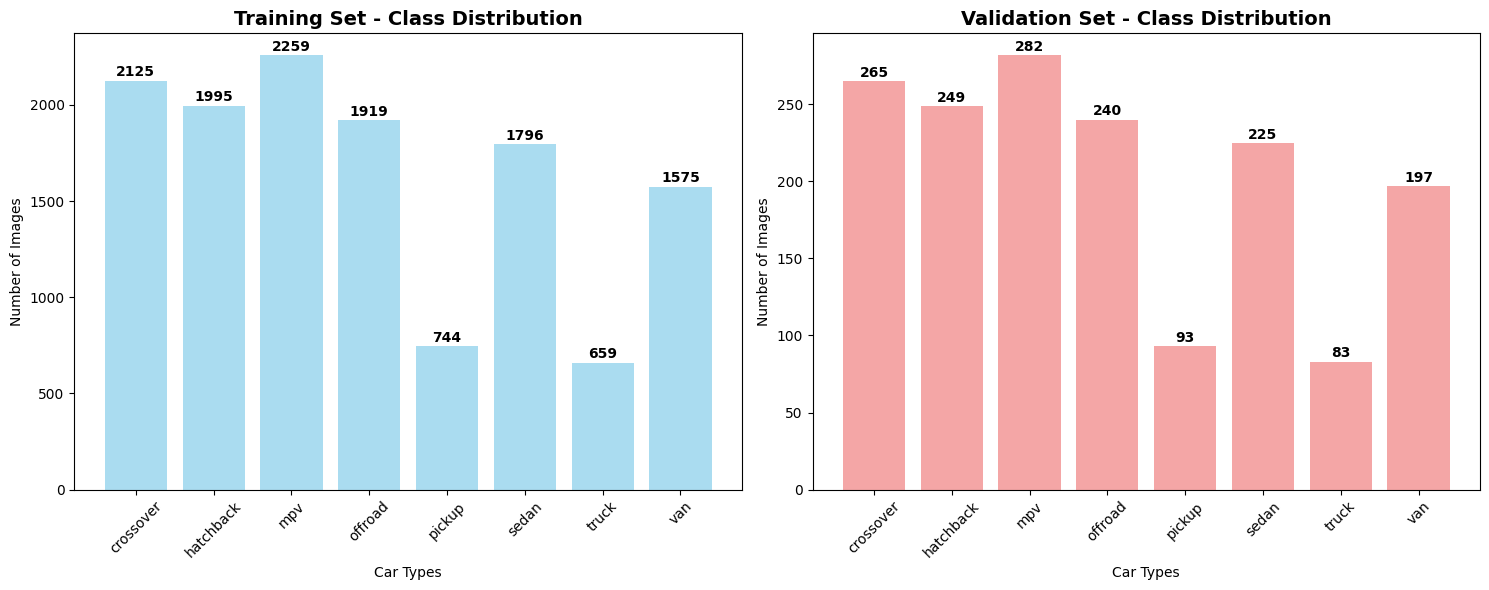


=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===
Using device: cuda
Logging to TensorBoard: logs/train_classification/run_1750702416
Using weighted CrossEntropyLoss with weights: tensor([0.7689, 0.8190, 0.7233, 0.8515, 2.1962, 0.9098, 2.4795, 1.0375],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
crossover    2125     16.3      % 1.06           x
hatchback    1995     15.3      % 1.13           x
mpv          2259     17.3      % 1.00           x
offroad      1919     14.7      % 1.18           x
pickup       744      5.7       % 3.04           x
sedan        1796     13.7      % 1.26           x
truck        659      5.0       % 3.43           x
van          1575     12.0      % 1.43           x

📈 Imbalance Factor: 3.43x (Most frequent / Least frequent)
⚠️  Moderate imbalance detected. Weighted loss recommended.
Trainer initialized successfully!
Tr

In [ ]:
# Training configuration

from models.classification.train_classification import CarClassifierTrainer
from models.classification.train_classification_eval import DatasetExplorer


CONFIG = {
    "train_dir": f"{DATASET_DIR}/train",
    "val_dir": f"{DATASET_DIR}/val",
    "num_classes": 8,
    "embed_dim": 192,
    "num_heads": 8,
    "dropout": 0.2,
    "learning_rate": 1e-4,
    "batch_size": 128,
    "num_epochs": 50,
    "result_path": f'models/classification/results/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 8,
    "early_stopping_patience": 7,
    "early_stopping_delta": 0.001,
    "early_stopping_verbose": True,
}

# Generate and summary report
explorer = DatasetExplorer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
)
explorer.summary_report()

# Initialize the trainer
print("\n=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    embed_dim=CONFIG["embed_dim"],
    num_heads=CONFIG["num_heads"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
    early_stopping_patience=CONFIG["early_stopping_patience"],
    early_stopping_delta=CONFIG["early_stopping_delta"],
    early_stopping_verbose=CONFIG["early_stopping_verbose"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

In [12]:
# Start training with detailed tracking
start_time = time.time()

# Execute training
training_results = trainer.train()

# Print training results
total_time = time.time() - start_time
print(f"\n=== Training Completed in {total_time:.2f} seconds ===")

Starting training with detailed tracking and early stopping...
Early Stopping - Patience: 7, Delta: 0.001
Model parameters: 15,651,140
Trainable parameters: 15,651,140

Epoch 1/50


100%|██████████| 103/103 [01:35<00:00,  1.08it/s, loss=2.38]


Validation accuracy: 25.15%
Validation loss: 1.7928
Train Loss: 2.0328 | Train Acc: 18.80%
Val Loss: 1.7928 | Val Acc: 25.15%
Time: 101.69s | LR: 1.00e-04
🎉 New best accuracy: 25.15%
Validation loss decreased (inf --> 1.792780).  Saving model ...

Epoch 2/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=1.81]


Validation accuracy: 33.72%
Validation loss: 1.7016
Train Loss: 1.8723 | Train Acc: 23.68%
Val Loss: 1.7016 | Val Acc: 33.72%
Time: 99.72s | LR: 1.00e-04
🎉 New best accuracy: 33.72%
Validation loss decreased (1.792780 --> 1.701628).  Saving model ...

Epoch 3/50


100%|██████████| 103/103 [01:32<00:00,  1.12it/s, loss=2.27]


Validation accuracy: 36.23%
Validation loss: 1.6404
Train Loss: 1.8036 | Train Acc: 27.44%
Val Loss: 1.6404 | Val Acc: 36.23%
Time: 98.55s | LR: 1.00e-04
🎉 New best accuracy: 36.23%
Validation loss decreased (1.701628 --> 1.640386).  Saving model ...

Epoch 4/50


100%|██████████| 103/103 [01:34<00:00,  1.10it/s, loss=1.38]


Validation accuracy: 39.66%
Validation loss: 1.5510
Train Loss: 1.7116 | Train Acc: 30.29%
Val Loss: 1.5510 | Val Acc: 39.66%
Time: 100.21s | LR: 1.00e-04
🎉 New best accuracy: 39.66%
Validation loss decreased (1.640386 --> 1.551049).  Saving model ...

Epoch 5/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=2.33]


Validation accuracy: 44.06%
Validation loss: 1.4816
Train Loss: 1.6588 | Train Acc: 33.20%
Val Loss: 1.4816 | Val Acc: 44.06%
Time: 99.93s | LR: 1.00e-04
🎉 New best accuracy: 44.06%
Validation loss decreased (1.551049 --> 1.481597).  Saving model ...

Epoch 6/50


100%|██████████| 103/103 [01:33<00:00,  1.11it/s, loss=1.08]


Validation accuracy: 47.49%
Validation loss: 1.4121
Train Loss: 1.5791 | Train Acc: 36.54%
Val Loss: 1.4121 | Val Acc: 47.49%
Time: 99.63s | LR: 1.00e-04
🎉 New best accuracy: 47.49%
Validation loss decreased (1.481597 --> 1.412059).  Saving model ...

Epoch 7/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=1.88]


Validation accuracy: 47.61%
Validation loss: 1.3810
Train Loss: 1.5092 | Train Acc: 39.63%
Val Loss: 1.3810 | Val Acc: 47.61%
Time: 100.18s | LR: 1.00e-04
🎉 New best accuracy: 47.61%
Validation loss decreased (1.412059 --> 1.380980).  Saving model ...

Epoch 8/50


100%|██████████| 103/103 [01:32<00:00,  1.11it/s, loss=1.43]


Validation accuracy: 50.12%
Validation loss: 1.3504
Train Loss: 1.4351 | Train Acc: 43.12%
Val Loss: 1.3504 | Val Acc: 50.12%
Time: 98.69s | LR: 1.00e-04
🎉 New best accuracy: 50.12%
Validation loss decreased (1.380980 --> 1.350433).  Saving model ...

Epoch 9/50


100%|██████████| 103/103 [01:32<00:00,  1.12it/s, loss=1.29]


Validation accuracy: 53.24%
Validation loss: 1.2675
Train Loss: 1.3791 | Train Acc: 45.48%
Val Loss: 1.2675 | Val Acc: 53.24%
Time: 98.36s | LR: 1.00e-04
🎉 New best accuracy: 53.24%
Validation loss decreased (1.350433 --> 1.267543).  Saving model ...

Epoch 10/50


100%|██████████| 103/103 [01:31<00:00,  1.12it/s, loss=0.963]


Validation accuracy: 56.24%
Validation loss: 1.2059
Train Loss: 1.2987 | Train Acc: 48.28%
Val Loss: 1.2059 | Val Acc: 56.24%
Time: 97.95s | LR: 1.00e-04
🎉 New best accuracy: 56.24%
Validation loss decreased (1.267543 --> 1.205858).  Saving model ...

Epoch 11/50


100%|██████████| 103/103 [01:35<00:00,  1.08it/s, loss=1.3] 


Validation accuracy: 58.81%
Validation loss: 1.1575
Train Loss: 1.2367 | Train Acc: 51.22%
Val Loss: 1.1575 | Val Acc: 58.81%
Time: 101.53s | LR: 1.00e-04
🎉 New best accuracy: 58.81%
Validation loss decreased (1.205858 --> 1.157459).  Saving model ...

Epoch 12/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=1.36]


Validation accuracy: 59.98%
Validation loss: 1.1386
Train Loss: 1.1844 | Train Acc: 53.37%
Val Loss: 1.1386 | Val Acc: 59.98%
Time: 100.12s | LR: 1.00e-04
🎉 New best accuracy: 59.98%
Validation loss decreased (1.157459 --> 1.138556).  Saving model ...

Epoch 13/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=0.864]


Validation accuracy: 61.57%
Validation loss: 1.0720
Train Loss: 1.1190 | Train Acc: 56.15%
Val Loss: 1.0720 | Val Acc: 61.57%
Time: 100.10s | LR: 1.00e-04
🎉 New best accuracy: 61.57%
Validation loss decreased (1.138556 --> 1.071973).  Saving model ...

Epoch 14/50


100%|██████████| 103/103 [01:34<00:00,  1.09it/s, loss=1.25]


Validation accuracy: 64.75%
Validation loss: 1.0400
Train Loss: 1.0723 | Train Acc: 57.86%
Val Loss: 1.0400 | Val Acc: 64.75%
Time: 100.71s | LR: 1.00e-04
🎉 New best accuracy: 64.75%
Validation loss decreased (1.071973 --> 1.040042).  Saving model ...

Epoch 15/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=0.845]


Validation accuracy: 64.38%
Validation loss: 1.0265
Train Loss: 1.0245 | Train Acc: 59.43%
Val Loss: 1.0265 | Val Acc: 64.38%
Time: 100.32s | LR: 1.00e-04
Validation loss decreased (1.040042 --> 1.026490).  Saving model ...

Epoch 16/50


100%|██████████| 103/103 [01:31<00:00,  1.12it/s, loss=0.841]


Validation accuracy: 65.36%
Validation loss: 1.0022
Train Loss: 0.9697 | Train Acc: 61.56%
Val Loss: 1.0022 | Val Acc: 65.36%
Time: 97.82s | LR: 1.00e-04
🎉 New best accuracy: 65.36%
Validation loss decreased (1.026490 --> 1.002240).  Saving model ...

Epoch 17/50


100%|██████████| 103/103 [01:34<00:00,  1.10it/s, loss=1.02] 


Validation accuracy: 66.28%
Validation loss: 0.9886
Train Loss: 0.9392 | Train Acc: 63.41%
Val Loss: 0.9886 | Val Acc: 66.28%
Time: 100.33s | LR: 1.00e-04
🎉 New best accuracy: 66.28%
Validation loss decreased (1.002240 --> 0.988552).  Saving model ...

Epoch 18/50


100%|██████████| 103/103 [01:33<00:00,  1.11it/s, loss=0.86] 


Validation accuracy: 66.77%
Validation loss: 1.0017
Train Loss: 0.8817 | Train Acc: 65.47%
Val Loss: 1.0017 | Val Acc: 66.77%
Time: 99.52s | LR: 1.00e-04
🎉 New best accuracy: 66.77%
EarlyStopping counter: 1 out of 7

Epoch 19/50


100%|██████████| 103/103 [01:31<00:00,  1.12it/s, loss=1.04] 


Validation accuracy: 66.71%
Validation loss: 0.9963
Train Loss: 0.8362 | Train Acc: 67.03%
Val Loss: 0.9963 | Val Acc: 66.71%
Time: 97.83s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 20/50


100%|██████████| 103/103 [01:32<00:00,  1.11it/s, loss=0.766]


Validation accuracy: 69.52%
Validation loss: 0.9402
Train Loss: 0.8124 | Train Acc: 68.13%
Val Loss: 0.9402 | Val Acc: 69.52%
Time: 99.47s | LR: 1.00e-04
🎉 New best accuracy: 69.52%
Validation loss decreased (0.988552 --> 0.940209).  Saving model ...

Epoch 21/50


100%|██████████| 103/103 [01:31<00:00,  1.12it/s, loss=0.904]


Validation accuracy: 67.75%
Validation loss: 0.9601
Train Loss: 0.7779 | Train Acc: 69.40%
Val Loss: 0.9601 | Val Acc: 67.75%
Time: 97.92s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 22/50


100%|██████████| 103/103 [01:32<00:00,  1.11it/s, loss=0.602]


Validation accuracy: 69.89%
Validation loss: 0.9130
Train Loss: 0.7371 | Train Acc: 70.91%
Val Loss: 0.9130 | Val Acc: 69.89%
Time: 99.04s | LR: 1.00e-04
🎉 New best accuracy: 69.89%
Validation loss decreased (0.940209 --> 0.912958).  Saving model ...

Epoch 23/50


100%|██████████| 103/103 [01:32<00:00,  1.11it/s, loss=0.615]


Validation accuracy: 71.18%
Validation loss: 0.9113
Train Loss: 0.7189 | Train Acc: 71.66%
Val Loss: 0.9113 | Val Acc: 71.18%
Time: 98.96s | LR: 1.00e-04
🎉 New best accuracy: 71.18%
Validation loss decreased (0.912958 --> 0.911284).  Saving model ...

Epoch 24/50


100%|██████████| 103/103 [01:34<00:00,  1.10it/s, loss=0.574]


Validation accuracy: 72.22%
Validation loss: 0.8974
Train Loss: 0.6690 | Train Acc: 73.43%
Val Loss: 0.8974 | Val Acc: 72.22%
Time: 100.39s | LR: 1.00e-04
🎉 New best accuracy: 72.22%
Validation loss decreased (0.911284 --> 0.897352).  Saving model ...

Epoch 25/50


100%|██████████| 103/103 [01:35<00:00,  1.08it/s, loss=0.524]


Validation accuracy: 71.48%
Validation loss: 0.9067
Train Loss: 0.6308 | Train Acc: 74.82%
Val Loss: 0.9067 | Val Acc: 71.48%
Time: 101.58s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 26/50


100%|██████████| 103/103 [01:34<00:00,  1.09it/s, loss=0.482]


Validation accuracy: 70.69%
Validation loss: 0.9192
Train Loss: 0.6139 | Train Acc: 75.95%
Val Loss: 0.9192 | Val Acc: 70.69%
Time: 100.67s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 27/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=0.419]


Validation accuracy: 71.54%
Validation loss: 0.8984
Train Loss: 0.5839 | Train Acc: 76.91%
Val Loss: 0.8984 | Val Acc: 71.54%
Time: 99.84s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 28/50


100%|██████████| 103/103 [01:34<00:00,  1.10it/s, loss=0.713]


Validation accuracy: 71.54%
Validation loss: 0.9259
Train Loss: 0.5799 | Train Acc: 76.82%
Val Loss: 0.9259 | Val Acc: 71.54%
Time: 100.10s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 29/50


100%|██████████| 103/103 [01:32<00:00,  1.11it/s, loss=0.525]


Validation accuracy: 73.26%
Validation loss: 0.8743
Train Loss: 0.5816 | Train Acc: 77.00%
Val Loss: 0.8743 | Val Acc: 73.26%
Time: 99.54s | LR: 1.00e-04
🎉 New best accuracy: 73.26%
Validation loss decreased (0.897352 --> 0.874290).  Saving model ...

Epoch 30/50


100%|██████████| 103/103 [01:32<00:00,  1.11it/s, loss=0.356]


Validation accuracy: 72.64%
Validation loss: 0.8884
Train Loss: 0.5322 | Train Acc: 78.72%
Val Loss: 0.8884 | Val Acc: 72.64%
Time: 98.82s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 31/50


100%|██████████| 103/103 [01:32<00:00,  1.12it/s, loss=0.699]


Validation accuracy: 73.38%
Validation loss: 0.9233
Train Loss: 0.5128 | Train Acc: 79.26%
Val Loss: 0.9233 | Val Acc: 73.38%
Time: 98.32s | LR: 1.00e-04
🎉 New best accuracy: 73.38%
EarlyStopping counter: 2 out of 7

Epoch 32/50


100%|██████████| 103/103 [01:32<00:00,  1.12it/s, loss=0.647]


Validation accuracy: 72.40%
Validation loss: 0.8913
Train Loss: 0.4851 | Train Acc: 80.65%
Val Loss: 0.8913 | Val Acc: 72.40%
Time: 98.45s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 33/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=0.601]


Validation accuracy: 73.93%
Validation loss: 0.8926
Train Loss: 0.4908 | Train Acc: 80.19%
Val Loss: 0.8926 | Val Acc: 73.93%
Time: 99.71s | LR: 1.00e-04
🎉 New best accuracy: 73.93%
EarlyStopping counter: 4 out of 7

Epoch 34/50


100%|██████████| 103/103 [01:33<00:00,  1.10it/s, loss=0.48] 


Validation accuracy: 74.30%
Validation loss: 0.8921
Train Loss: 0.4664 | Train Acc: 81.34%
Val Loss: 0.8921 | Val Acc: 74.30%
Time: 100.09s | LR: 1.00e-04
🎉 New best accuracy: 74.30%
EarlyStopping counter: 5 out of 7

Epoch 35/50


100%|██████████| 103/103 [01:32<00:00,  1.11it/s, loss=0.689]


Validation accuracy: 74.36%
Validation loss: 0.9281
Train Loss: 0.4550 | Train Acc: 81.85%
Val Loss: 0.9281 | Val Acc: 74.36%
Time: 99.12s | LR: 1.00e-04
🎉 New best accuracy: 74.36%
EarlyStopping counter: 6 out of 7

Epoch 36/50


100%|██████████| 103/103 [01:33<00:00,  1.11it/s, loss=1.22] 


Validation accuracy: 73.93%
Validation loss: 0.9022
Train Loss: 0.4547 | Train Acc: 81.86%
Val Loss: 0.9022 | Val Acc: 73.93%
Time: 99.41s | LR: 1.00e-04
EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered at epoch 36
Best validation loss: 0.874290

Training completed!
Training stopped early at epoch 36 due to no improvement in validation loss
Best validation accuracy: 74.36%
Loading best model with validation loss: 0.874290
Best accuracy model saved to models/results/carvit_model_20250623_181336_best_acc.pth

=== Training Completed in 3588.24 seconds ===


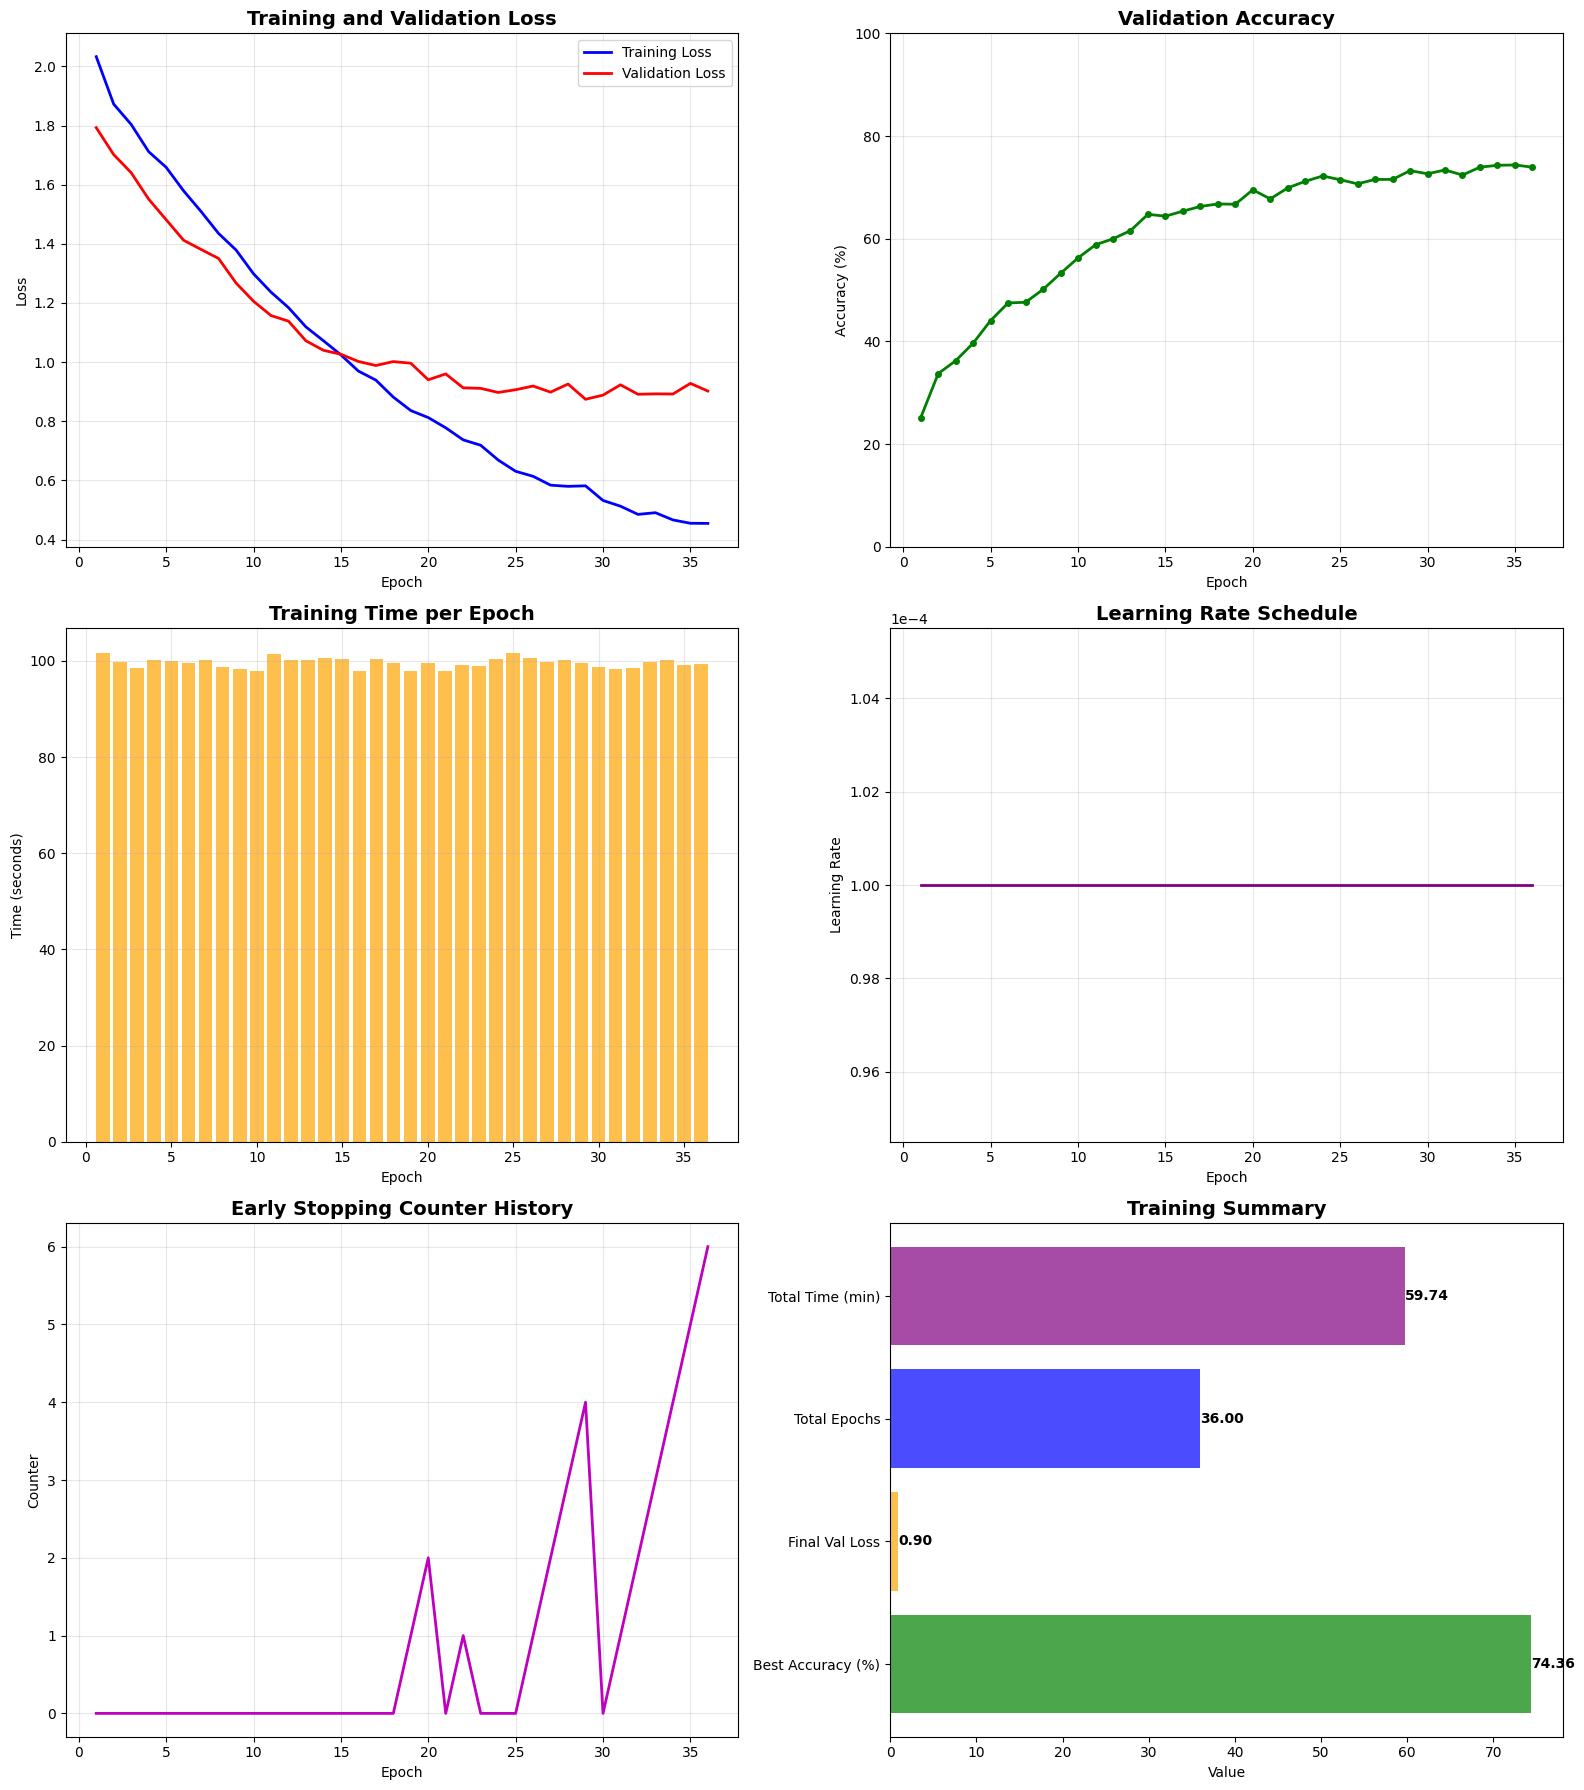


🛑 Early Stopping Analysis:
Early stopping triggered at epoch 36/50.
Epochs saved: 14
Time saved: ~23.2 minutes
Efficiency gain: 28.0%

📈 Detailed Training Statistics:
- Loss Reduction: 2.0328 → 0.4547 (77.6% improvement)
- Best Accuracy: 74.36% (Epoch 35)
- Total Training Time: 59.74 minutes
- Average Time per Epoch: 99.57s
- Fastest Epoch: 97.82s
- Slowest Epoch: 101.69s
- Early Stopping Counter History: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 6]

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate  ES_Counter
    32      0.4851    0.8913         72.40       98.45         0.0001           2
    33      0.4908    0.8926         73.93       99.71         0.0001           3
    34      0.4664    0.8921         74.30      100.09         0.0001           4
    35      0.4550    0.9281         74.36       99.12         0.0001           5
    36      0.4547    0.9022

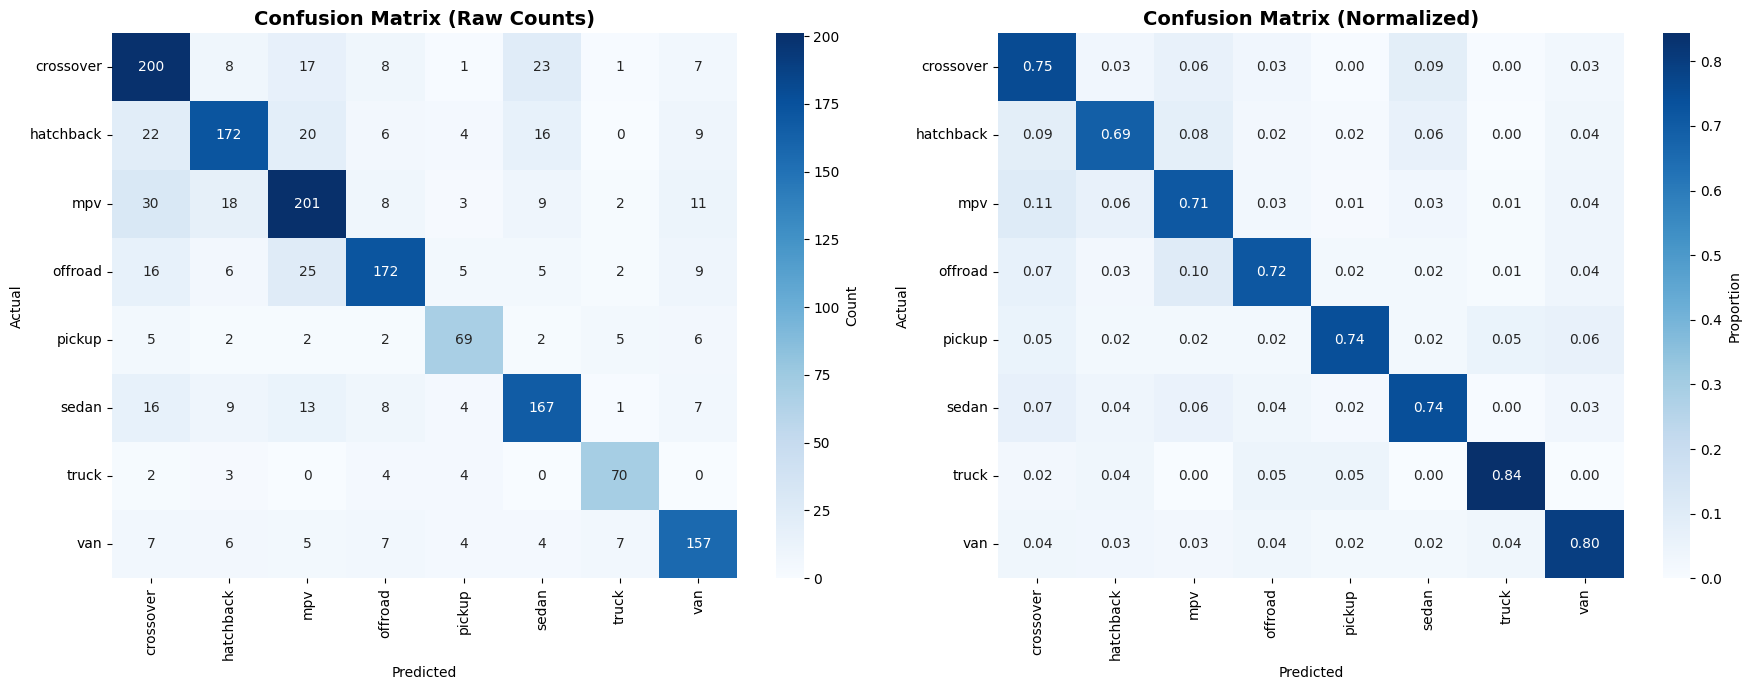


📊 Detailed Classification Report:
              precision    recall  f1-score   support

   crossover     0.6711    0.7547    0.7105       265
   hatchback     0.7679    0.6908    0.7273       249
         mpv     0.7102    0.7128    0.7115       282
     offroad     0.8000    0.7167    0.7560       240
      pickup     0.7340    0.7419    0.7380        93
       sedan     0.7389    0.7422    0.7406       225
       truck     0.7955    0.8434    0.8187        83
         van     0.7621    0.7970    0.7792       197

    accuracy                         0.7393      1634
   macro avg     0.7475    0.7499    0.7477      1634
weighted avg     0.7418    0.7393    0.7394      1634


⚖️ Class Imbalance Impact Analysis:

📈 Class Group Performance:
Minority Classes (4): ['pickup', 'sedan', 'truck', 'van']
Average Accuracy: 78.11%
Majority Classes (4): ['crossover', 'hatchback', 'mpv', 'offroad']
Average Accuracy: 71.87%
Performance Gap: 6.24% (Minority better)


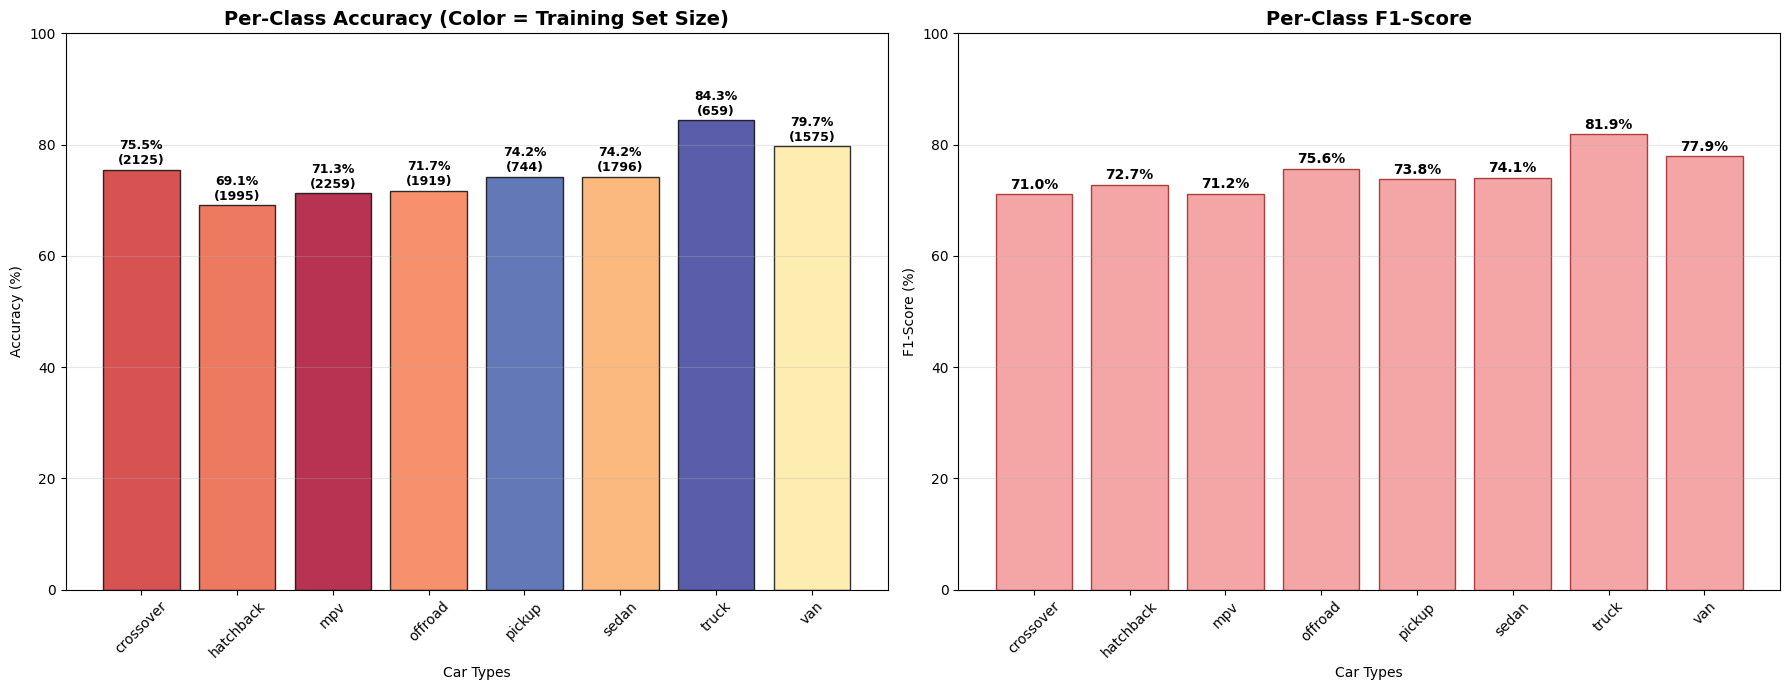

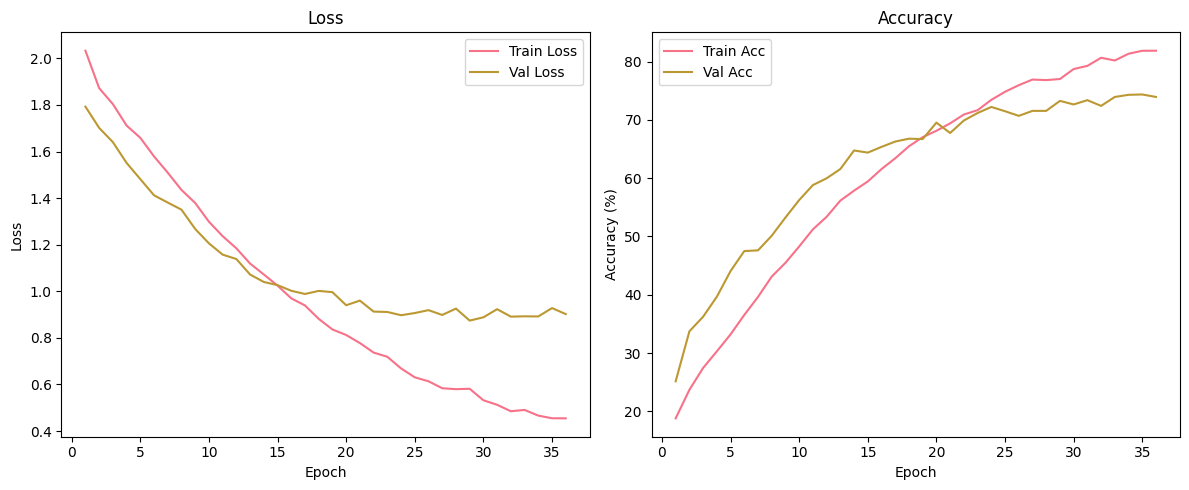

Final Train Loss: 0.4547 | Final Val Loss: 0.9022
Final Train Acc: 81.86% | Final Val Acc: 73.93%

🛑 Early stopping summary saved to: models/classification/reports/early_stopping_summary_20250623_191612.json

💾 Training history saved to: models/classification/reports/training_history_20250623_191611.csv
📊 Class performance saved to: models/classification/reports/class_performance_20250623_191612.csv
🎯 Best model saved to: models/results/carvit_model_20250623_181336.pth
🏆 Best accuracy model saved to: models/results/carvit_model_20250623_181336_best_acc.pth

🎉 Training Analysis Complete!
🎯 Final Summary:
- Training completed in 36 epochs (planned: 50)
- Best validation accuracy: 74.36%
- Early stopping: Activated
- Total training time: 59.74 minutes
- Time saved by early stopping: 23.2 minutes
- Class imbalance: Moderate (ratio: 3.43x)
- Model saved with best validation loss: 0.874290


In [13]:
# Generate the full report
from models.classification.train_classification_eval import TrainingEvaluation

report = TrainingEvaluation(trainer, CONFIG, training_results)

report.full_report()

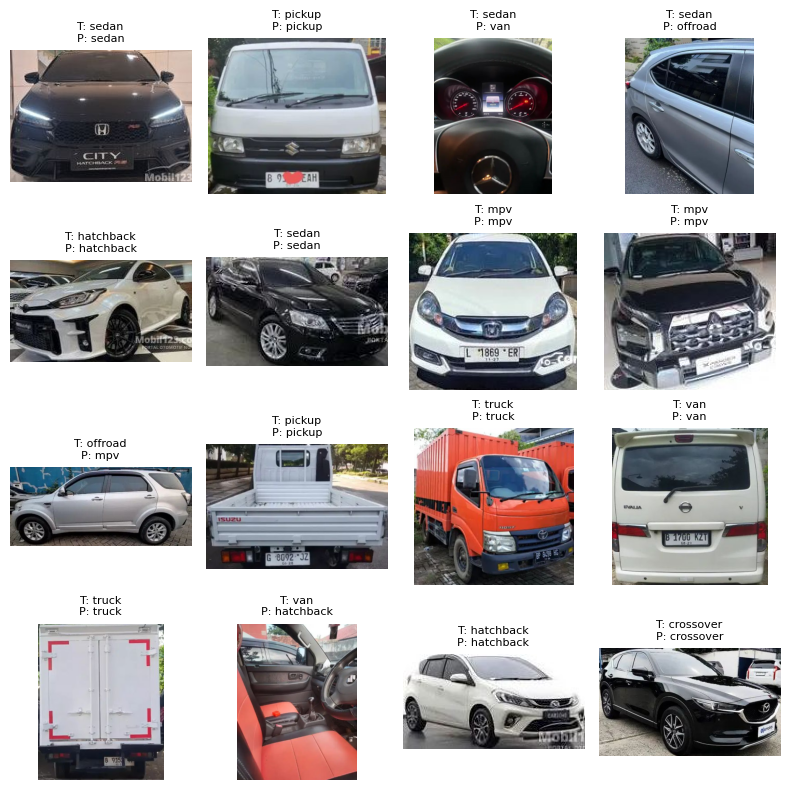

Test Accuracy: 75.00% (12/16)


In [8]:
# Test the classification model test images and display predictions
import os

from models.classification.test_classification import CarClassificationTester

test_dir = f"{DATASET_DIR}/test"
class_names = [
    d for d in sorted(os.listdir(test_dir)) if os.path.isdir(os.path.join(test_dir, d))
]
tester = CarClassificationTester(
    test_dir=test_dir,
    class_names=class_names,
    model_path=None,
    grid_rows=4,
    grid_cols=4,
    num_classes=CONFIG["num_classes"],
)

tester.plot_predictions()